# Analysis of GFP mean and integrated intensity vs GFP concentration

## Config

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import intake_io
import os
import re
import numpy as np
import pylab as plt
import seaborn as sns
from skimage import io
import pandas as pd
from tqdm import tqdm
from skimage.measure import regionprops_table

from am_utils.utils import walk_dir, imsave
from am_utils.parallel import run_parallel

from lib import rescale_intensity

## Data & parameters

### Data
`input_dir`: folder with images to be analyzed

`output_dir`: folder to save results


### Other parameters

`max_threads`: number of processes to run in parallel; default is 30


## Specify data paths and analysis parameters

### Please provide data paths:

In [2]:
input_dir = "/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff"
output_dir = "/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration"

### Other parameters:

In [3]:
max_threads = 30    # number of processes to run in parallel

### The following code lists all datasets in the input directory:

In [4]:
#################################
#  Don't modify the code below  #
#################################
samples = walk_dir(input_dir)

print(f'{len(samples)} images were found:')
print(np.array(samples))

132 images were found:
['/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_-_Position_1_XY1621491671.tif'
 '/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_-_Position_2_XY1621491672.tif'
 '/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_-_Position_3_XY1621491673.tif'
 '/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_-_Position_4_XY1621491674.tif'
 '/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_-_Position_5_XY1621491675.tif'
 '/research/sharedresources/cbi/data_exchange/kriwagrp/0520201_GFPcalibration/converted_tiff/Tiffs/1.78nM/05192021_GFPcalibration_1.78nM_

### The following code loads a sample dataset:

In [5]:
#################################
#  Don't modify the code below  #
#################################

sample = samples[np.random.randint(len(samples))]
dataset = intake_io.imload(sample)
print(dataset)


<xarray.Dataset>
Dimensions:  (x: 992, y: 992, z: 61)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 108.7 108.8 108.9 109.0
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 108.7 108.8 108.9 109.0
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8 1.0 ... 11.2 11.4 11.6 11.8 12.0
Data variables:
    image    (z, y, x) uint16 3475 3558 3561 3563 3629 ... 3166 3124 3248 3142
Attributes:
    metadata:  {'spacing_units': {}}


### The following code displays the maxprojection of the puncta channel:

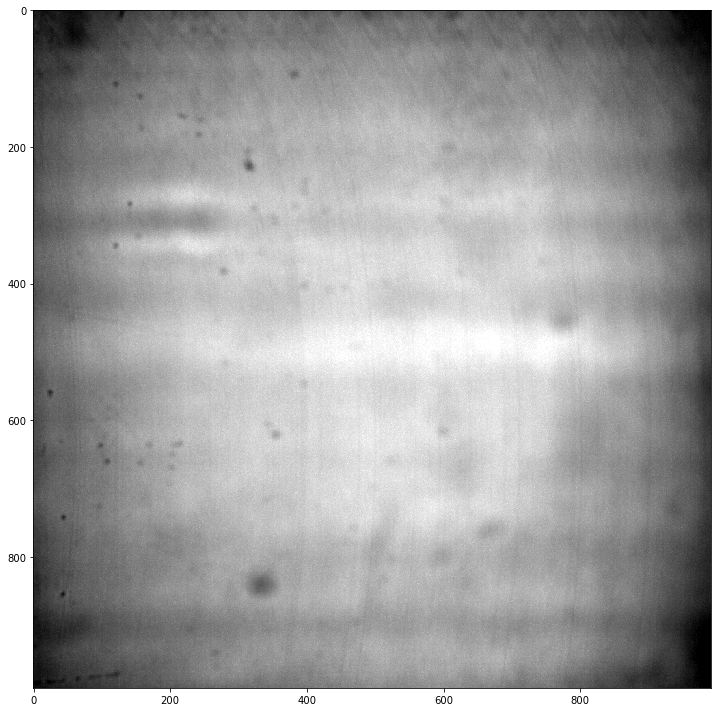

In [6]:
#################################
#  Don't modify the code below  #
#################################

plt.figure(figsize=(10,10))
io.imshow(rescale_intensity(dataset['image'].data.max(0)))

### The following code quantifies all input images:

In [7]:
%%time
#################################
#  Don't modify the code below  #
#################################

def quantify(item, input_dir, output_dir,  **kwargs_to_ignore):
    sample = item
    dataset = intake_io.imload(sample)
      
    puncta_signal = np.array(dataset['image'].data)

    stats = pd.DataFrame(regionprops_table(label_image=np.ones_like(puncta_signal),
                                           intensity_image=puncta_signal,
                                           properties=['area', 'mean_intensity']))

    stats = stats.rename(columns={'area': 'image volume pix', 'mean_intensity':  'GFP mean intensity per image'}) 
    stats['GFP integrated intensity per image'] = stats['GFP mean intensity per image'] * stats['image volume pix']
      
    condition = sample.split('/')[-2]
    p_nm = re.compile(rf'([0-9]*\.?[0-9]+)nM')
    p_um = re.compile(rf'([0-9]*\.?[0-9]+)uM')
    conc_nM = 0
    if len(p_nm.findall(condition)) > 0:
        conc_nM = float(p_nm.findall(condition)[0])
    if len(p_um.findall(condition)) > 0:
        conc_nM = float(p_um.findall(condition)[0]) * 1000
    
    stats['condition'] = condition
    stats['GFP concentration nM'] = conc_nM
    stats['sample'] = sample.split('/')[-1]
    
    sample_name = sample[len(input_dir):].replace(sample.split('.')[-1], '')
    
    # save the stats
    os.makedirs(os.path.dirname(output_dir + '/quantification' + sample_name + 'csv'), exist_ok=True)
    stats.to_csv(output_dir + '/quantification' + sample_name + 'csv', index=False)
    
    return

# specify the analysis arguments
kwargs = dict()
kwargs['items'] = samples
kwargs['input_dir'] = input_dir
kwargs['output_dir'] = output_dir
kwargs['max_threads'] = max_threads

for item in tqdm(samples):
    quantify(item=item, **kwargs)

# combine the cell stats
print('Combining stats...')
stats = pd.DataFrame()
for fn in walk_dir(os.path.join(output_dir, 'quantification')):
    stats = pd.concat([stats, pd.read_csv(fn)], ignore_index=False)
stats.to_csv(output_dir + '/quantification.csv', index=False)

100%|██████████| 132/132 [03:08<00:00,  1.43s/it]


Combining stats...
CPU times: user 2min 18s, sys: 36.2 s, total: 2min 54s
Wall time: 3min 9s


In [8]:
stats

,image volume pix,GFP mean intensity per image,GFP integrated intensity per image,condition,GFP concentration nM,sample
0,60027904,101.146311,6.071601e+09,1.78nM,1.78,05192021_GFPcalibration_1.78nM - Position 1_XY...
0,60027904,101.102539,6.068974e+09,1.78nM,1.78,05192021_GFPcalibration_1.78nM - Position 2_XY...
0,60027904,101.081730,6.067724e+09,1.78nM,1.78,05192021_GFPcalibration_1.78nM - Position 3_XY...
0,60027904,101.066858,6.066832e+09,1.78nM,1.78,05192021_GFPcalibration_1.78nM - Position 4_XY...
0,60027904,101.089892,6.068214e+09,1.78nM,1.78,05192021_GFPcalibration_1.78nM - Position 5_XY...
...,...,...,...,...,...,...
0,60027904,101.220993,6.076084e+09,Empty,0.00,05192021_GFPcalibration_empty_-_Position_2_XY1...
0,60027904,101.207284,6.075261e+09,Empty,0.00,05192021_GFPcalibration_empty_-_Position_3_XY1...
0,60027904,101.198864,6.074756e+09,Empty,0.00,05192021_GFPcalibration_empty_-_Position_4_XY1...
0,60027904,101.175419,6.073348e+09,Empty,0.00,05192021_GFPcalibration_empty_-_Position_5_XY1...


### The following code plots cell stats over conditions:

/research/sharedresources/cbi/common/Anna/anaconda3/envs/nup98_puncta/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


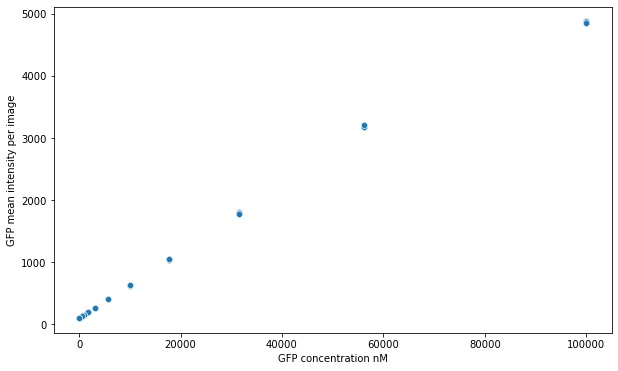

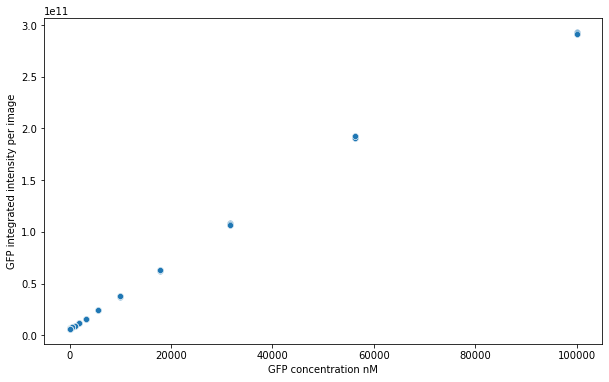

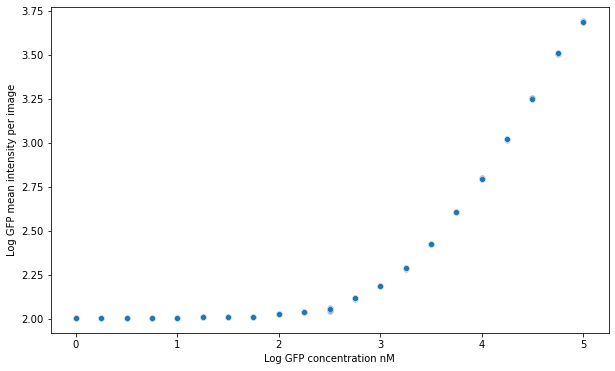

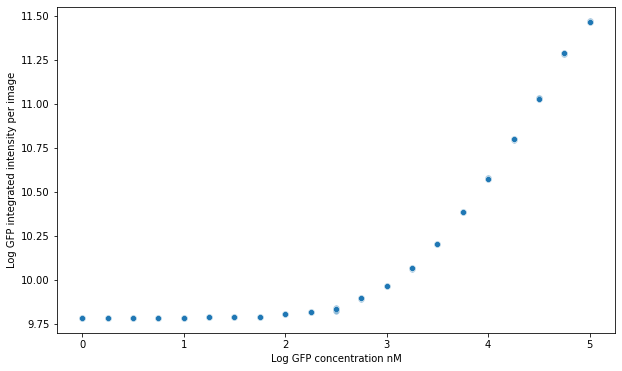

In [11]:
#################################
#  Don't modify the code below  #
#################################
os.makedirs(output_dir + '/plots', exist_ok=True)
stats = pd.read_csv(output_dir + '/quantification.csv')
for col in ['GFP concentration nM', 'GFP mean intensity per image', 'GFP integrated intensity per image']:
    stats['Log ' + col] = np.log10(stats[col])

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x = 'GFP concentration nM', y='GFP mean intensity per image', data=stats) 
plt.savefig(output_dir + '/plots/' + 'mean_intensity_vs_GFP_concentration.png')   

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x = 'GFP concentration nM', y='GFP integrated intensity per image', data=stats) 
plt.savefig(output_dir + '/plots/' + 'integrated_intensity_vs_GFP_concentration.png')   

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x = 'Log ' + 'GFP concentration nM', y='Log ' + 'GFP mean intensity per image', data=stats) 
plt.savefig(output_dir + '/plots/' + 'mean_intensity_vs_GFP_concentration_logscale.png')   

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x = 'Log ' + 'GFP concentration nM', y='Log ' + 'GFP integrated intensity per image', data=stats) 
plt.savefig(output_dir + '/plots/' + 'integrated_intensity_vs_GFP_concentration_logscale.png')   